In [1]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras import layers
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

## Data Set Up

In [2]:
import kagglehub

# Download latest version
download_path = kagglehub.dataset_download("fmena14/crowd-counting")

print("Path to dataset files:", download_path)

100%|██████████| 1.18G/1.18G [00:09<00:00, 133MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# local
data_folder = Path('../data')
# g-drive
data_folder = Path('/content/drive/MyDrive/Colab Notebooks/USD/6_computer_vision/AAI-521-Computer-Vision/data')
# local colab
data_folder = Path(download_path)
label_path = data_folder / 'labels.csv'
imgs_folder = data_folder / 'frames' /'frames'

In [5]:
df = pd.read_csv(label_path)

In [6]:
df.head(2)

,id,count
0,1,35
1,2,41


##### adding full img path column

In [7]:
def get_img_filename(image_id: int)-> Path:
    image_id = str(image_id).rjust(6, '0')
    img_name = f'seq_{image_id}.jpg'
    return img_name

In [8]:
def get_img_path(image_id: int, image_folder: Path)-> Path:
    image_id = str(image_id).rjust(6, '0')
    img_name = f'seq_{image_id}.jpg'
    img_path = image_folder / img_name
    return img_path

In [9]:
df['img_file_name'] = df.id.apply(lambda x: get_img_filename(x))

In [10]:
df.head(3)

,id,count,img_file_name
0,1,35,seq_000001.jpg
1,2,41,seq_000002.jpg
2,3,41,seq_000003.jpg


#### splitting into train, test, and validation

In [11]:
train_val_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=88,
                                     #stratify=df['count']
                                    )

train_df, val_df = train_test_split(train_val_df,
                                    test_size=0.25,
                                    random_state=42,
                                    )

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [12]:
len(test_df)

400

In [13]:
len(train_df)

1200

In [14]:
len(val_df)

400

#### augmentation

In [15]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255 # Normalize pixel values
)
#val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

In [17]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=imgs_folder,
    x_col='img_file_name',
    y_col='count',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

Found 1200 validated image filenames.


In [18]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=imgs_folder,
    x_col='img_file_name',
    y_col='count',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=imgs_folder,
    x_col='img_file_name',
    y_col='count',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

Found 400 validated image filenames.
Found 400 validated image filenames.


In [19]:
def manual_img_preprocessing(img_path):
    img = load_img(img_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    return img_array

---

### Model Layout

##### configs

In [31]:
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
kernel_size = (3, 3)
pool_size = (2, 2)

#### model layout

In [68]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),

        layers.Conv2D(64, kernel_size=kernel_size,
                      activation='relu', padding='same', strides=2),
        layers.Conv2D(128, kernel_size=kernel_size,
                      activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=pool_size, strides=2),

        layers.Conv2D(256, kernel_size=kernel_size,
                      activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=pool_size, strides=2),

        layers.Conv2D(256, kernel_size=kernel_size,
                      activation='relu', padding='same'),
        layers.Conv2D(128, kernel_size=kernel_size,
                      activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=pool_size, strides=2),

        layers.Conv2D(64, kernel_size=kernel_size,
                      activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=pool_size, strides=2),

        layers.Dropout(.25),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(1, activation="relu") # we can use relu bc its counts of people, therefore can't be negative
    ]
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 16, 16, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,855,041 (7.08 MB)

 Trainable params: 1,855,041 (7.08 MB)

 Non-trainable params: 0 (0.00 B)

#### compile the model

In [69]:
l_rate = 0.0004
optimizer = keras.optimizers.Adam(learning_rate=l_rate)
model.compile(
    optimizer=optimizer,
    loss="mse",
    metrics=["mae"]
)

## Training

In [70]:
early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=30, # 20 may be a bit too patient
        min_delta=0.001,
        mode='min',
        restore_best_weights=True
    )

In [71]:
import tensorflow as tf

# Check if GPU is available
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [72]:
print(tf.test.is_built_with_cuda())

True


In [73]:
model.fit(
        train_generator,
        epochs=200, # Set a high number of epochs, as early stopping will manage the actual stopping point
        validation_data=val_generator,
        callbacks=[early_stopping]
    )

Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - loss: 402.0398 - mae: 16.5379 - val_loss: 59.6470 - val_mae: 6.2062
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - loss: 58.9858 - mae: 6.1632 - val_loss: 57.6465 - val_mae: 5.9973
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - loss: 58.5071 - mae: 6.1328 - val_loss: 62.0289 - val_mae: 6.1164
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - loss: 65.5724 - mae: 6.4411 - val_loss: 58.0349 - val_mae: 6.2624
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - loss: 51.6916 - mae: 5.7178 - val_loss: 97.7629 - val_mae: 8.5087
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - loss: 50.9619 - mae: 5.6737 - val_loss: 76.3485 - val_mae: 7.4398
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - loss: 49.5696 - mae: 5.6255 - val_loss: 37.6185 - val_mae: 4.9990
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - loss: 47.1966 - mae: 5.4128 - val_loss: 55.5004 - val_mae: 6.2796
Epoch 9/200
38/38 ━━━━━━━━━━━

In [74]:
model_folder = Path('/content/drive/MyDrive/Colab Notebooks/USD/6_computer_vision/AAI-521-Computer-Vision/dev_spencer/models')

In [75]:
# save model
model_file_name = 'cnn-counting-model-25Nov2025-0004.keras'
full_model_path = model_folder / model_file_name
model.save(full_model_path)

In [40]:
# load model
#model = load_model(full_model_path)

In [76]:
model_hist = model.history.history

In [77]:
import pickle
history_path = model_folder / 'cnn-counting-model-history-25Nov2025-0004.pickle'

with open(history_path, 'wb') as file_pi:
    pickle.dump(model_hist, file_pi)

In [78]:

train_loss = model_hist['loss']
val_loss = model_hist['val_loss']
train_mae = model_hist['mae'] # mean absolute error
val_mae = model_hist['val_mae']

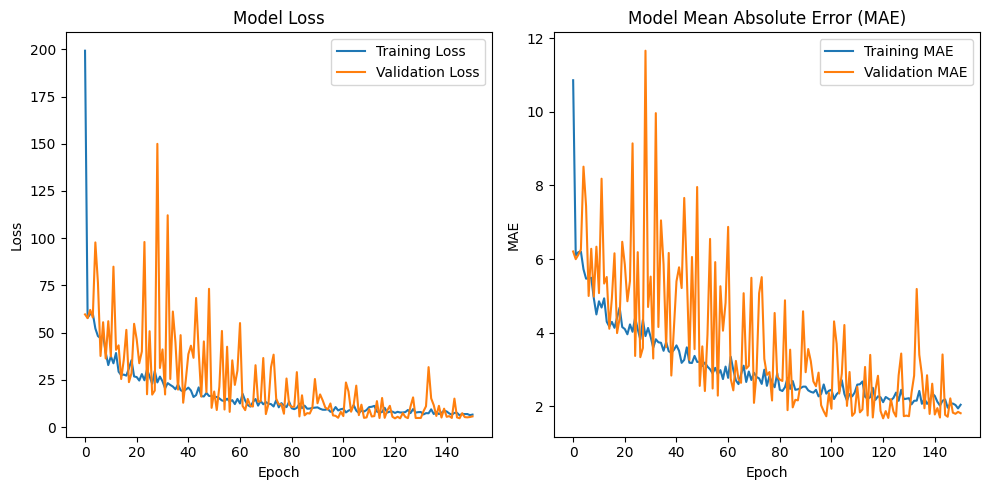

In [79]:
# Plot training & validation loss values
plt.figure( figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

The oscillating loss and MAE could be indicative that the learning rate was too high on this training.

## Evaluating Test Set

In [80]:
results = model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE
    # steps ensures the generator covers the whole dataset exactly
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 4.2893 - mae: 1.6390


In [81]:
test_loss = results[0] # This is the Mean Squared Error (MSE)
test_mae = results[1]  # This is the Mean Absolute Error (MAE)

In [82]:
print(f'Loss for the test dataset = {round(test_loss, 3)}')
print(f'Mean Absolute Error for the test dataset = {round(test_mae,3)}')

Loss for the test dataset = 4.466
Mean Absolute Error for the test dataset = 1.662


In [83]:
predictions = model.predict(test_generator)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step


In [90]:
#predictions.squeeze()

In [87]:
true = test_generator.labels

In [91]:
eval_df = pd.DataFrame({
    'actual': true,
    'predicted': predictions.squeeze()
})

In [92]:
eval_df['error'] = eval_df.predicted - eval_df.actual
eval_df['error_abs'] = abs(eval_df.error)

In [95]:
import seaborn as sns

Text(0.5, 1.2, 'Actual Count vs Error')

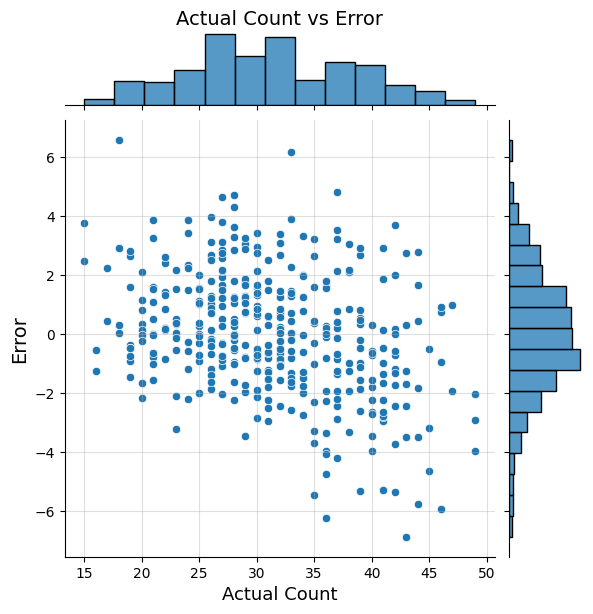

In [107]:

sns.jointplot(x='actual',
              y='error',
              data=eval_df,
              kind='scatter',
              )
plt.xlabel('Actual Count', fontsize=13)
plt.ylabel('Error', fontsize=14)
plt.grid(':', alpha=.4)
plt.title('Actual Count vs Error', y=1.2, fontsize=14)

## Demo

In [ ]:
img_id = df.id.iloc[0]
label = df['count'].iloc[0]
img_path = get_img_path(img_id, imgs_folder)

In [ ]:
example_img = load_img(img_path)

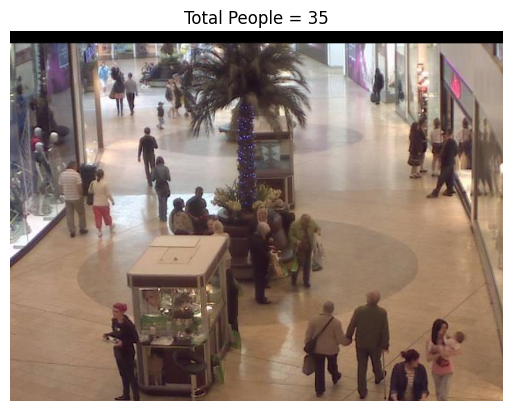

In [ ]:
plt.imshow(example_img)
plt.title(f'Total People = {label}')
plt.axis('off')
plt.show()

In [ ]:
preprocess_img = manual_img_preprocessing(img_path)
prediction_result = model.predict(preprocess_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step


In [ ]:
prediction_result

array([[33.591026]], dtype=float32)

In [ ]:
final_result = int(round(prediction_result[0][0]))

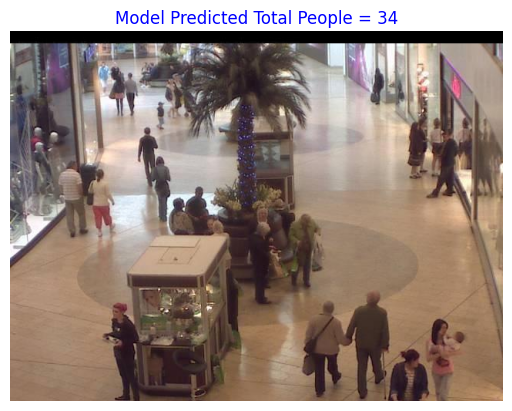

In [ ]:
plt.imshow(example_img)
plt.title(f'Model Predicted Total People = {final_result}', color = 'blue')
plt.axis('off')
plt.show()

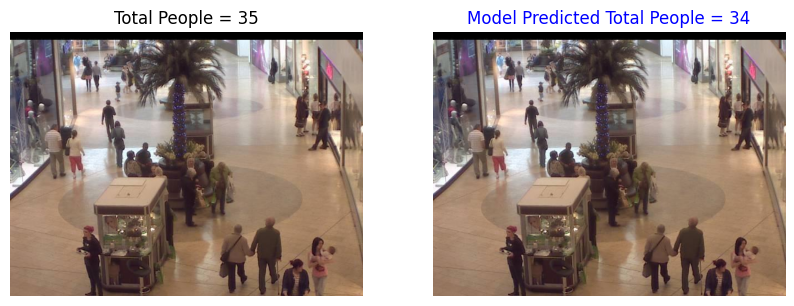

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(example_img)
ax[0].set_title(f'Total People = {label}')
ax[0].set_axis_off()


ax[1].imshow(example_img)
ax[1].set_title(f'Model Predicted Total People = {final_result}', color = 'blue')
ax[1].set_axis_off()